In [532]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize, imread
from tqdm import tqdm_notebook, tnrange
import cv2
from glob import glob
import pickle
import peakutils
from scipy.signal import find_peaks_cwt

%matplotlib inline
#%matplotlib qt

In [35]:
ROWS = 6
COLS = 9
CAL_IMAGE_SIZE = (720, 1280, 3)
CALC_CAL_POINTS = True
CAL_IMAGE_PATH = 'camera_cal/calibration*.jpg'
CALIBRATION_PATH = 'camera_cal/calibration.p'

def get_camera_calibration(path_pattern, rows, cols, image_size):
    objp = np.zeros((rows*cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:cols, 0:rows].T.reshape(-1,2)

    objpoints = []
    imgpoints = []

    images = glob(path_pattern)
    cal_images = np.zeros((len(images), *CAL_IMAGE_SIZE), dtype=np.uint8)

    successfull_cnt = 0
    for idx, fname in enumerate(tqdm_notebook(images, desc='Processing image')):
        img = imread(fname)
        if img.shape[0] != CAL_IMAGE_SIZE[0] or img.shape[1] != CAL_IMAGE_SIZE[1]:
            img = imresize(img, CAL_IMAGE_SIZE)

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (cols, rows), None) 

        if ret == True:
            successfull_cnt +=1

            objpoints.append(objp)
            imgpoints.append(corners)

            img = cv2.drawChessboardCorners(img, (cols, rows), corners, ret)
            cal_images[idx] = img

    print("%s/%s camera calibration images processed." % (successfull_cnt,len(images)))
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, CAL_IMAGE_SIZE[:-1], None, None)
    
    calibration = {'objpoints': objpoints,
                   'imgpoints': imgpoints,
                   'cal_images': cal_images,
                   'mtx': mtx,
                   'dist': dist,
                   'rvecs': rvecs,
                   'tvecs': tvecs}
    
    return calibration

if CALC_CAL_POINTS:
    calibration = get_camera_calibration(CAL_IMAGE_PATH, ROWS, COLS, CAL_IMAGE_SIZE)
    with open(CALIBRATION_PATH, 'wb') as f:
        pickle.dump(calibration, file=f)
else:
    with open(CALIBRATION_PATH, "rb" ) as f:
        calibration = pickle.load(f)   


17/19 camera calibration images processed.


In [1098]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def abs_sobel_thresh(img_ch, orient='x', sobel_kernel=3, thresh=(0, 255)):  
    if orient == 'x':
        axis = (1, 0)
    elif orient == 'y':
        axis = (0, 1)
    else:
        raise ValueError('orient has to be "x" or "y" not "%s"' % orient)
    
    sobel = cv2.Sobel(img_ch, cv2.CV_64F, *axis)
    abss = np.absolute(sobel)
    
    scale_factor = np.max(abss)/255
    abss = (abss/scale_factor).astype(np.uint8)
    
    binary_output = np.zeros_like(abss)
    binary_output[(abss > thresh[0]) & (abss < thresh[1])] = 1
    
    return binary_output

def mag_thresh(img_ch, sobel_kernel=3, thresh=(0, 255)):    
    sobelx = cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_grad_mag = np.sqrt(sobelx**2+sobely**2)

    scale_factor = np.max(abs_grad_mag)/255
    abs_grad_mag = (abs_grad_mag/scale_factor).astype(np.uint8)
    
    mag_binary = np.zeros_like(abs_grad_mag)
    mag_binary[(abs_grad_mag > thresh[0]) & (abs_grad_mag < thresh[1])] = 1

    return mag_binary

def dir_threshold(img_ch, sobel_kernel=3, thresh=(0, np.pi/2)):    
    sobelx = cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    with np.errstate(divide='ignore', invalid='ignore'):
        abs_grad_dir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(abs_grad_dir)
        dir_binary[(abs_grad_dir > thresh[0]) & (abs_grad_dir < thresh[1])] = 1

    return dir_binary

def hls_select(img, ch, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_ch = hls[:,:,ch]
    retval, ch_binary = cv2.threshold(s_ch.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)

    return ch_binary

def hsv_select(img, ch, thresh=(0, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,ch]
    retval, ch_binary = cv2.threshold(v_channel.astype('uint8'), 220, 255, cv2.THRESH_BINARY)

    return ch_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def weighted_img(img, initial_img, α=0.5):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, 1-α, 0)

In [1099]:
def image_pipline(img, ksize=3):
    img = cal_undistort(img, calibration['objpoints'], calibration['imgpoints'])
    img = gaussian_blur(img, kernel_size=5)
        
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,2]
    
    v_binary = hsv_select(img, 2, thresh=(220, 255))
    s_binary = hls_select(img, 2, thresh=(220, 255))

    
    gradx = abs_sobel_thresh(v_channel, orient='x', sobel_kernel=ksize, thresh=(20, 255))
    grady = abs_sobel_thresh(v_channel, orient='y', sobel_kernel=ksize, thresh=(30, 255))
    mag_binary = mag_thresh(v_channel, sobel_kernel=ksize, thresh=(60, 255))
    dir_binary = dir_threshold(v_channel, sobel_kernel=ksize, thresh=(np.pi/4, np.pi/3))

    combined = np.zeros_like(grady)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 255
    
    color_binary = np.dstack((np.zeros_like(s_binary), s_binary, v_binary))
    gray = cv2.cvtColor(color_binary, cv2.COLOR_RGB2GRAY)
    _, final = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    return v_binary|s_binary

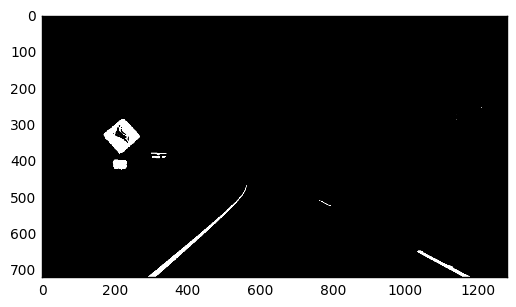

In [1100]:
orig_img = imread('test_images/test2.jpg')
img = image_pipline(orig_img)

plt.imshow(img, cmap='gray')

In [1101]:
imshape = img.shape
top_width = 100
top_offset = 350
vertices = np.array([[(0,imshape[0]),
                      (imshape[1]/2-top_width, top_offset),
                      (imshape[1]/2+top_width, top_offset),
                      (imshape[1],imshape[0])]],
                    dtype=np.int32)

src = np.float32([
    (280, 720),
    (530, 500),
    (780, 500),
    (1200, 720)])

dst = np.float32([
    (280, 720),
    (280, 0),
    (1200, 0),
    (1200, 720)])

#img = region_of_interest(img, vertices)
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)
img = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

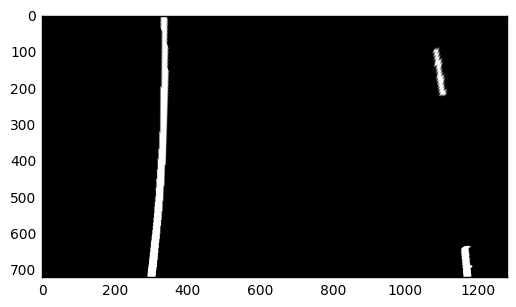

In [1102]:
plt.imshow(img, cmap='gray')

In [1103]:
def color_peak_square(lane_img, img, start, end, peak, pixels_per_step, ch):
    lane_img[start:end,
        peak-pixels_per_step//2:peak+pixels_per_step//2,
        ch] = \
    img[start:end,
        peak-pixels_per_step//2:peak+pixels_per_step//2]

In [1104]:
HIST_STEPS = 10
histograms = []

lane_img = np.zeros((*img.shape, 3), dtype=np.uint8)

for i in range(HIST_STEPS):
    pixels_per_step = img.shape[0]//HIST_STEPS
    start = i * pixels_per_step
    end = start + pixels_per_step
    histogram = np.sum(img[start:end,:], axis=0)
    
    peaks = find_peaks_cwt(histogram, np.arange(1, 50))
    if len(peaks) == 2:
        color_peak_square(lane_img, img, start, end, peaks[0], pixels_per_step, 2)
        color_peak_square(lane_img, img, start, end, peaks[1], pixels_per_step, 0)
    elif len(peaks) == 1:
        if peaks[0] < img.shape[1]:
            color_peak_square(lane_img, img, start, end, peaks[0], pixels_per_step, 2)
        else:
            color_peak_square(lane_img, img, start, end, peaks[0], pixels_per_step, 0)

    histograms.append(histogram)

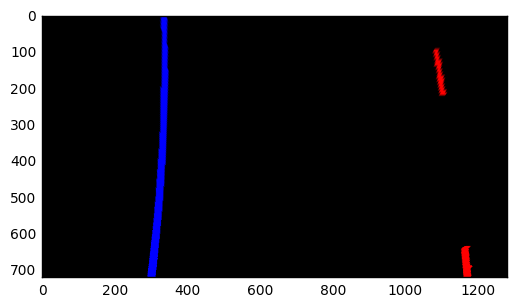

In [1105]:
plt.imshow(lane_img)

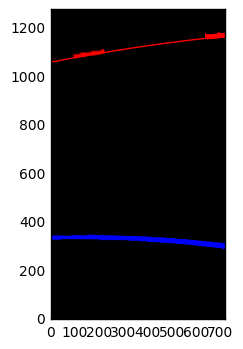

In [1106]:
_ = plt.imshow(np.transpose(lane_img, axes=[1,0,2]))
xp = np.linspace(0, 1280, 1280)

y_left, x_left = (lane_img[:,:,2]==255).nonzero()
z_left = np.polyfit(y_left, x_left, 2)
p_left = np.poly1d(z_left)
_ = plt.plot(p_left(xp), '-', color='b')

y_right, x_right = (lane_img[:,:,0]==255).nonzero()
z_right = np.polyfit(y_right, x_right, 2)
p_right = np.poly1d(z_right)
_ = plt.plot(p_right(xp), '-', color='r')

_ = plt.ylim(0,lane_img.shape[1])
_ = plt.xlim(0,lane_img.shape[0])

In [1107]:
points_left = np.zeros((HIST_STEPS + 1, 2))
points_right = np.zeros((HIST_STEPS + 1, 2))

index = 0
for i in range(HIST_STEPS + 1):
    pixels_per_step = img.shape[0]//HIST_STEPS
    start = img.shape[0] - i * pixels_per_step
    
    points_left[i] = [p_left(start), start]
    
    points_right[i] = [p_right(start), start]

    
lane_area = np.concatenate((points_left, points_right[::-1]), axis=0)

In [1108]:
lane_area.shape

(22, 2)

In [1109]:
lane_img = cv2.fillPoly(lane_img, np.int32([lane_area]), (0,255,0))

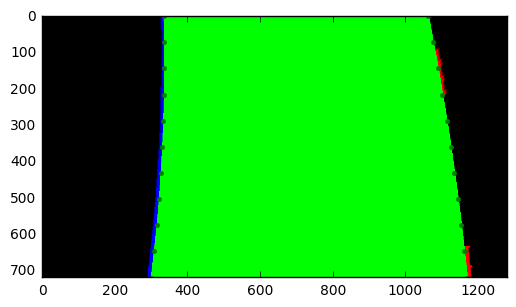

In [1110]:
plt.plot(lane_area[:,0], lane_area[:,1], '.', color='g')

plt.imshow(lane_img)
# _ = plt.ylim(0,lane_img.shape[0])
# _ = plt.xlim(0,lane_img.shape[1])
plt.show()

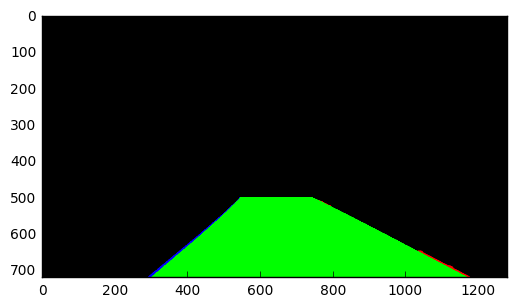

In [1111]:
lane_mask = cv2.warpPerspective(lane_img, M_inv, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(lane_mask)

In [1112]:
detected = np.copy(orig_img)

detected[lane_mask[:,:,0] > 0, 0] = 255
detected[lane_mask[:,:,0] > 0, 1:] = 0

detected[lane_mask[:,:,1] > 0, 1] = 150
detected[lane_mask[:,:,1] > 0, 2] = 0
detected[lane_mask[:,:,1] > 0, 0] = 0

detected[lane_mask[:,:,2] > 0, 2] = 255
detected[lane_mask[:,:,2] > 0, :2] = 0

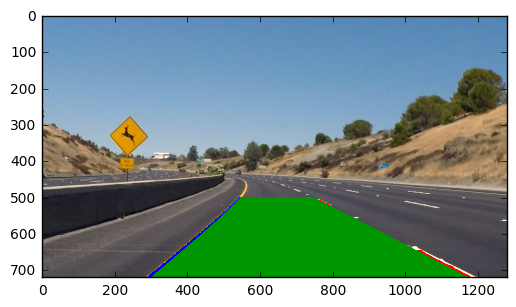

In [1113]:
plt.imshow(detected)